# 导入相关软件包

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 参数配置

In [2]:
# 随机种子
def seed_pytorch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
config_para = {
    'data_path': '../shared_datasets/heart_failure_clinical_records_dataset.csv',
    'seed':42,
}

In [5]:
seed_pytorch(seed=config_para['seed'])

# 数据读入

In [6]:
# 创建DataFrame
df = pd.read_csv(config_para['data_path'])
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [7]:
# 查看一些基本信息
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


# 数据加载和处理

In [8]:
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

In [9]:
# 分离特征和标签
features = df.drop('DEATH_EVENT', axis=1).to_numpy()
labels = df['DEATH_EVENT'].to_numpy()

In [10]:
features.shape, labels.shape

((299, 12), (299,))

In [11]:
# 特征归一化
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 部分准备

In [12]:
# 评估函数
def evaluate(y_true, y_pred):
    """计算并返回各项评估指标"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    return metrics

In [13]:
# K-fold交叉验证初始化
kf = KFold(n_splits=10, shuffle=True, random_state=config_para['seed'])

In [14]:
all_metrics = {} # 保存所有评估指标

# SVM实现：libsvm

In [15]:
from libsvm.svmutil import *

In [16]:
all_metrics['libsvm'] = []

In [17]:
# 1. 线性核
# 当前实验所有fold的结果
current_exp_metrics = []

# 进行交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # 分割训练集和测试集
    X_train, X_test = features[train_index].tolist(), features[test_index].tolist()
    y_train, y_test = labels[train_index].tolist(), labels[test_index].tolist()
    
    # 训练
    prob = svm_problem(y_train, X_train)
    param_1 = svm_parameter('-t 0 -c 1')
    svm_linear_1 = svm_train(prob, param_1)
    
    # 预测
    y_pred, _, _ = svm_predict(y_test, X_test, svm_linear_1)
    
    # 计算指标
    fold_metrics = evaluate(y_test, y_pred)
    current_exp_metrics.append(fold_metrics)
    
    # 打印每折的结果
    print(f"\n第 {fold} 折结果:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

# 计算所有fold的平均结果并输出
avg_metrics = {
    'accuracy': np.mean([m['accuracy'] for m in current_exp_metrics]),
    'precision': np.mean([m['precision'] for m in current_exp_metrics]),
    'recall': np.mean([m['recall'] for m in current_exp_metrics]),
    'f1': np.mean([m['f1'] for m in current_exp_metrics])
}
print("\n所有折的平均结果:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# 存储平均结果
all_metrics['libsvm'].append({'linear': avg_metrics})


Accuracy = 80% (24/30) (classification)

第 1 折结果:
accuracy: 0.8000
precision: 1.0000
recall: 0.5000
f1: 0.6667
Accuracy = 80% (24/30) (classification)

第 2 折结果:
accuracy: 0.8000
precision: 0.8182
recall: 0.6923
f1: 0.7500
Accuracy = 83.3333% (25/30) (classification)

第 3 折结果:
accuracy: 0.8333
precision: 0.8182
recall: 0.7500
f1: 0.7826
Accuracy = 83.3333% (25/30) (classification)

第 4 折结果:
accuracy: 0.8333
precision: 0.8333
recall: 0.7692
f1: 0.8000
Accuracy = 80% (24/30) (classification)

第 5 折结果:
accuracy: 0.8000
precision: 0.4444
recall: 0.8000
f1: 0.5714
Accuracy = 96.6667% (29/30) (classification)

第 6 折结果:
accuracy: 0.9667
precision: 1.0000
recall: 0.8889
f1: 0.9412
Accuracy = 86.6667% (26/30) (classification)

第 7 折结果:
accuracy: 0.8667
precision: 0.7500
recall: 0.7500
f1: 0.7500
Accuracy = 80% (24/30) (classification)

第 8 折结果:
accuracy: 0.8000
precision: 0.6667
recall: 0.2857
f1: 0.4000
Accuracy = 73.3333% (22/30) (classification)

第 9 折结果:
accuracy: 0.7333
precision: 0.6667
re

In [18]:
# 2. 高斯核
# 当前实验所有fold的结果
current_exp_metrics = []

# 进行交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # 分割训练集和测试集
    X_train, X_test = features[train_index].tolist(), features[test_index].tolist()
    y_train, y_test = labels[train_index].tolist(), labels[test_index].tolist()
    
    # 训练
    prob = svm_problem(y_train, X_train)
    param_2 = svm_parameter('-t 2 -c 1 -g 0.5')
    svm_rbf_1 = svm_train(prob, param_2)
    
    # 预测
    y_pred, _, _ = svm_predict(y_test, X_test, svm_rbf_1)
    
    # 计算指标
    fold_metrics = evaluate(y_test, y_pred)
    current_exp_metrics.append(fold_metrics)
    
    # 打印每折的结果
    print(f"\n第 {fold} 折结果:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

# 计算所有fold的平均结果并输出
avg_metrics = {
    'accuracy': np.mean([m['accuracy'] for m in current_exp_metrics]),
    'precision': np.mean([m['precision'] for m in current_exp_metrics]),
    'recall': np.mean([m['recall'] for m in current_exp_metrics]),
    'f1': np.mean([m['f1'] for m in current_exp_metrics])
}
print("\n所有折的平均结果:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# 存储平均结果
all_metrics['libsvm'].append({'gaussian': avg_metrics})

Accuracy = 66.6667% (20/30) (classification)

第 1 折结果:
accuracy: 0.6667
precision: 1.0000
recall: 0.1667
f1: 0.2857
Accuracy = 60% (18/30) (classification)

第 2 折结果:
accuracy: 0.6000
precision: 1.0000
recall: 0.0769
f1: 0.1429
Accuracy = 60% (18/30) (classification)

第 3 折结果:
accuracy: 0.6000
precision: 0.0000
recall: 0.0000
f1: 0.0000
Accuracy = 56.6667% (17/30) (classification)

第 4 折结果:
accuracy: 0.5667
precision: 0.0000
recall: 0.0000
f1: 0.0000
Accuracy = 80% (24/30) (classification)

第 5 折结果:
accuracy: 0.8000
precision: 0.0000
recall: 0.0000
f1: 0.0000
Accuracy = 70% (21/30) (classification)

第 6 折结果:
accuracy: 0.7000
precision: 0.0000
recall: 0.0000
f1: 0.0000
Accuracy = 73.3333% (22/30) (classification)

第 7 折结果:
accuracy: 0.7333
precision: 0.5000
recall: 0.2500
f1: 0.3333
Accuracy = 76.6667% (23/30) (classification)

第 8 折结果:
accuracy: 0.7667
precision: 0.5000
recall: 0.1429
f1: 0.2222
Accuracy = 63.3333% (19/30) (classification)

第 9 折结果:
accuracy: 0.6333
precision: 1.0000
re

d:\anaconda3\envs\mindspore\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\mindspore\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\mindspore\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# 提取支持向量并对比
linear_support_vectors_1 = svm_linear_1.get_SV()
rbf_support_vectors_1 = svm_rbf_1.get_SV()

print(f"libsvm 线性核：{linear_support_vectors_1}")
print(f"libsvm 高斯核：{rbf_support_vectors_1}")

libsvm 线性核：[{1: -0.07022314934698967, 2: 1.1479675332361718, 3: -0.2754716537702538, 4: 1.1798304963002102, 5: 1.8549577561302433, 6: -0.7356881903374974, 7: 1.952487724775394, 8: -0.2845523523500058, 9: -1.2770261269349072, 10: 0.7356881903374974, 11: 1.454160697217929, 12: -1.5520673821702675}, {1: 0.35083297726931784, 2: -0.8711047752203891, 3: -0.4385829136237893, 4: -0.8475793795260129, 5: 2.2781474166543867, 6: -0.7356881903374974, 7: 7.535660178453291e-09, 8: 0.10275231751525779, 9: 0.31204383957802917, 10: -1.3592715135759477, 11: -0.6876819060735034, 12: -1.5520673821702675}, {1: -1.3333915291959122, 2: 1.1479675332361718, 3: 0.4120732770047756, 4: -0.8475793795260129, 5: -0.6841802070146189, 6: -0.7356881903374974, 7: -1.3043559496905983, 8: -0.2845523523500058, 9: 0.0850338443618954, 10: 0.7356881903374974, 11: -0.6876819060735034, 12: -1.5391615434898929}, {1: -0.9123354025796047, 2: 1.1479675332361718, 3: -0.4272270664187963, 4: -0.8475793795260129, 5: -0.00707675017598903

# SVM实现：sklearn

In [20]:
from sklearn.svm import SVC

In [21]:
all_metrics['sklearn'] = []

In [22]:
# 1. 线性核
svm_linear_2 = SVC(kernel='linear')

In [23]:
# 当前实验所有fold的结果
current_exp_metrics = []

# 进行交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # 分割训练集和测试集
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # 训练
    svm_linear_2.fit(X_train, y_train)
    
    # 预测
    y_pred = svm_linear_2.predict(X_test)
    
    # 计算指标
    fold_metrics = evaluate(y_test, y_pred)
    current_exp_metrics.append(fold_metrics)
    
    # 打印每折的结果
    print(f"\n第 {fold} 折结果:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

# 计算所有fold的平均结果并输出
avg_metrics = {
    'accuracy': np.mean([m['accuracy'] for m in current_exp_metrics]),
    'precision': np.mean([m['precision'] for m in current_exp_metrics]),
    'recall': np.mean([m['recall'] for m in current_exp_metrics]),
    'f1': np.mean([m['f1'] for m in current_exp_metrics])
}
print("\n所有折的平均结果:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# 存储平均结果
all_metrics['sklearn'].append({'linear': avg_metrics})


第 1 折结果:
accuracy: 0.8000
precision: 1.0000
recall: 0.5000
f1: 0.6667

第 2 折结果:
accuracy: 0.8000
precision: 0.8182
recall: 0.6923
f1: 0.7500

第 3 折结果:
accuracy: 0.8333
precision: 0.8182
recall: 0.7500
f1: 0.7826

第 4 折结果:
accuracy: 0.8333
precision: 0.8333
recall: 0.7692
f1: 0.8000

第 5 折结果:
accuracy: 0.8000
precision: 0.4444
recall: 0.8000
f1: 0.5714

第 6 折结果:
accuracy: 0.9667
precision: 1.0000
recall: 0.8889
f1: 0.9412

第 7 折结果:
accuracy: 0.8667
precision: 0.7500
recall: 0.7500
f1: 0.7500

第 8 折结果:
accuracy: 0.8000
precision: 0.6667
recall: 0.2857
f1: 0.4000

第 9 折结果:
accuracy: 0.7333
precision: 0.6667
recall: 0.6667
f1: 0.6667

第 10 折结果:
accuracy: 0.8621
precision: 0.5714
recall: 0.8000
f1: 0.6667

所有折的平均结果:
accuracy: 0.8295
precision: 0.7569
recall: 0.6903
f1: 0.6995


In [24]:
# 2. 高斯核
svm_rbf_2 = SVC(kernel='rbf', gamma='scale')

In [25]:
# 当前实验所有fold的结果
current_exp_metrics = []

# 进行交叉验证
for fold, (train_index, test_index) in enumerate(kf.split(features), 1):
    # 分割训练集和测试集
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # 训练
    svm_rbf_2.fit(X_train, y_train)
    
    # 预测
    y_pred = svm_rbf_2.predict(X_test)
    
    # 计算指标
    fold_metrics = evaluate(y_test, y_pred)
    current_exp_metrics.append(fold_metrics)
    
    # 打印每折的结果
    print(f"\n第 {fold} 折结果:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

# 计算所有fold的平均结果并输出
avg_metrics = {
    'accuracy': np.mean([m['accuracy'] for m in current_exp_metrics]),
    'precision': np.mean([m['precision'] for m in current_exp_metrics]),
    'recall': np.mean([m['recall'] for m in current_exp_metrics]),
    'f1': np.mean([m['f1'] for m in current_exp_metrics])
}
print("\n所有折的平均结果:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# 存储平均结果
all_metrics['sklearn'].append({'gaussian': avg_metrics})


第 1 折结果:
accuracy: 0.7667
precision: 0.8571
recall: 0.5000
f1: 0.6316

第 2 折结果:
accuracy: 0.7333
precision: 0.8571
recall: 0.4615
f1: 0.6000

第 3 折结果:
accuracy: 0.7333
precision: 0.7000
recall: 0.5833
f1: 0.6364

第 4 折结果:
accuracy: 0.6667
precision: 0.7143
recall: 0.3846
f1: 0.5000

第 5 折结果:
accuracy: 0.8000
precision: 0.4444
recall: 0.8000
f1: 0.5714

第 6 折结果:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000

第 7 折结果:
accuracy: 0.8667
precision: 0.7500
recall: 0.7500
f1: 0.7500

第 8 折结果:
accuracy: 0.8000
precision: 0.6000
recall: 0.4286
f1: 0.5000

第 9 折结果:
accuracy: 0.7000
precision: 0.6667
recall: 0.5000
f1: 0.5714

第 10 折结果:
accuracy: 0.8966
precision: 0.6667
recall: 0.8000
f1: 0.7273

所有折的平均结果:
accuracy: 0.7963
precision: 0.7256
recall: 0.6208
f1: 0.6488


In [27]:
# 提取支持向量并对比
linear_support_vectors_2 = svm_linear_2.support_vectors_
rbf_support_vectors_2 = svm_rbf_2.support_vectors_

print(f"sklearn 线性核：{linear_support_vectors_2}")
print(f"sklearn 高斯核：{rbf_support_vectors_2}")

sklearn 线性核：[[-0.99654663  1.14796753 -0.51807384 ... -1.35927151 -0.68768191
  -1.5262557 ]
 [-0.9123354   1.14796753 -0.43651821 ... -1.35927151 -0.68768191
  -1.30685645]
 [-0.07022315 -0.87110478  2.1412591  ...  0.73568819 -0.68768191
  -1.29395061]
 ...
 [-0.49127928 -0.87110478  1.48158761 ...  0.73568819 -0.68768191
   1.08072371]
 [ 0.35083298  1.14796753 -0.33431559 ...  0.73568819 -0.68768191
   1.35174632]
 [-0.49127928 -0.87110478  0.63712552 ...  0.73568819  1.4541607
   1.42918135]]
sklearn 高斯核：[[-0.99654663  1.14796753 -0.51807384 ... -1.35927151 -0.68768191
  -1.5262557 ]
 [-0.65970173 -0.87110478 -0.53562379 ...  0.73568819 -0.68768191
  -1.39719732]
 [-0.9123354   1.14796753 -0.43651821 ... -1.35927151 -0.68768191
  -1.30685645]
 ...
 [-0.49127928 -0.87110478  1.48158761 ...  0.73568819 -0.68768191
   1.08072371]
 [ 0.35083298  1.14796753 -0.33431559 ...  0.73568819 -0.68768191
   1.35174632]
 [-0.49127928 -0.87110478  0.63712552 ...  0.73568819  1.4541607
   1.42918

## 可视化

Accuracy = 63.9114% (68058/106488) (classification)


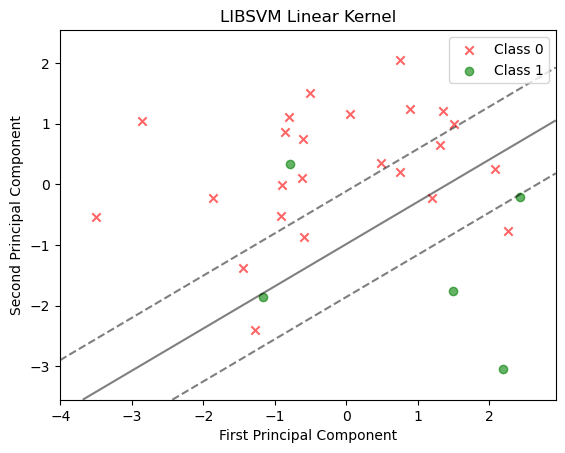

Accuracy = 96.2869% (102534/106488) (classification)


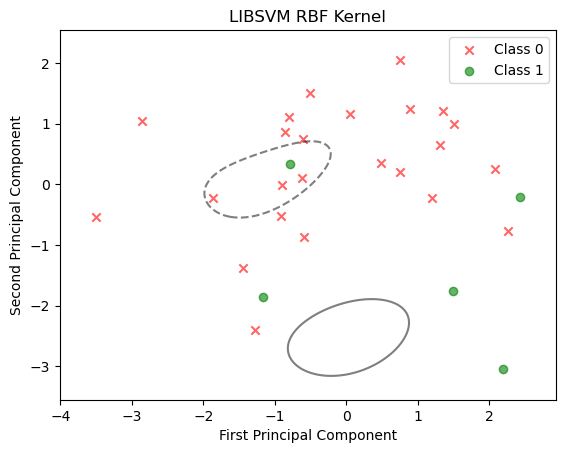

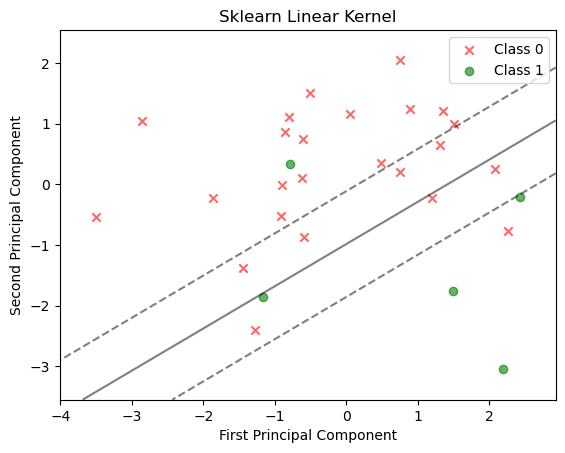

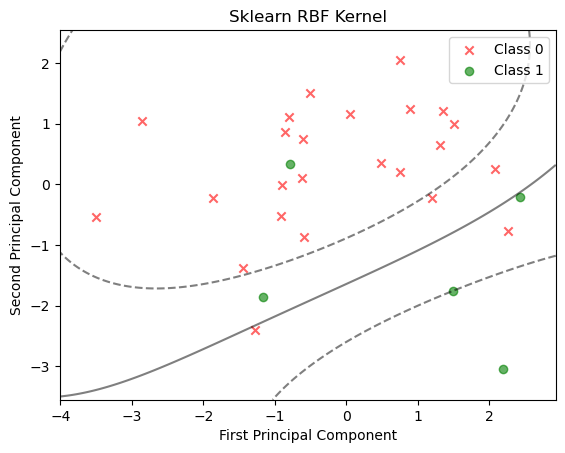

In [38]:
def get_decision_function(is_libsvm, model, X, pca=None, scaler=None):
    """获取决策函数值"""
    if is_libsvm:
        # 设置 -b 0 表示输出决策值而非概率
        zeros = [0] * len(X)
        _, _, decision_values = svm_predict(zeros, X.tolist(), model, '-b 0')
        # LIBSVM 对于二分类问题,决策值需要取负号才是标准形式
        return -np.array(decision_values).flatten()
    return model.decision_function(X)

def plot_decision_boundary(model, X, y, title, is_libsvm=False):
    """可视化SVM决策边界和支持向量"""
    # PCA降维
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # 创建网格
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    # 获取决策函数值
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = get_decision_function(is_libsvm, model, pca.inverse_transform(grid_points))
    Z = Z.reshape(xx.shape)
    
    # 决策边界和间隔
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], 
                alpha=0.5, linestyles=['--', '-', '--'])
    
    # 数据点
    plt.scatter(X_2d[y == 0, 0], X_2d[y == 0, 1], 
                c='red', marker='x', label='Class 0', alpha=0.6)
    plt.scatter(X_2d[y == 1, 0], X_2d[y == 1, 1], 
                c='green', marker='o', label='Class 1', alpha=0.6)
    
    # # 标注支持向量
    # if is_libsvm:
    #     sv = np.array([list(sv.values()) for sv in model.get_SV()])
    #     # 对支持向量进行相同的PCA降维
    #     sv_2d = pca.transform(sv)
    # else:
    #     sv = model.support_vectors_
    #     sv_2d = pca.transform(sv)
        
    # plt.scatter(sv_2d[:, 0], sv_2d[:, 1], s=100, linewidth=1, 
    #             facecolors='none', edgecolors='blue', 
    #             label='Support Vectors')
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.legend()
    plt.show()

# 获取最后一个fold的数据
last_fold = list(kf.split(features))[-1]
X_test_last = features[last_fold[1]]
y_test_last = labels[last_fold[1]]

# 可视化四个模型
plot_decision_boundary(svm_linear_1, X_test_last, y_test_last, 
                      'LIBSVM Linear Kernel', is_libsvm=True)
plot_decision_boundary(svm_rbf_1, X_test_last, y_test_last, 
                      'LIBSVM RBF Kernel', is_libsvm=True)
plot_decision_boundary(svm_linear_2, X_test_last, y_test_last, 
                      'Sklearn Linear Kernel')
plot_decision_boundary(svm_rbf_2, X_test_last, y_test_last, 
                      'Sklearn RBF Kernel')